Lambda School Data Science

*Unit 4, Sprint 1, Module 4*

---

# Topic Modeling (Prepare)

# Latent Dirchilet Allocation (LDA) Models (Prepare)
<a id="#p1"></a>

## Overview
LDA is a "generative probabilistic model". 

Let's play with a modoel available [here](https://lettier.com/projects/lda-topic-modeling/)

## Follow Along

## Challenge 

# Estimating LDA Models with Gensim (Learn)
<a id="#p1"></a>

## Overview
### A Litterary Introduction: *Jane Austen V. Charlotte Bronte*
Despite being born nearly forty years apart, modern fans often pit Jane Austen & Charlotte Bronte against one another in a battle for litterary  supremacy. The battle centers around the topics of education for women, courting, and marriage. The authors' similiar backgrounds naturally draw comparisons, but the modern fascination is probably due to novelility of British women publishing novels during the early 19th century. 

Can we help close a litterary battle for supremacy and simply acknowledge that the authors addressed different topics and deserve to be acknowledged as excellent authors each in their own right?

We're going to apply Latent Dirichlet Allocation a machine learning alogrithm for topic modeling to each of the author's novels to compare the distribution of topics in their novels.

In [3]:
import numpy as np
import gensim
import os
import re

from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora

from gensim.models.ldamulticore import LdaMulticore

import pandas as pd

C:\Users\soobt\Anaconda3\envs\jupyterlab\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [10]:
import spacy
nlp = spacy.load("en_core_web_lg")

### Novel Data
I grabbed the novel data pre-split into a bunch of smaller chuncks

In [4]:
path = './data/austen-brontë-split'

In [7]:
def tokenize(text):
    return [token.lemma_ for token in nlp(text) if (token.is_stop != True) and (token.is_punct != True)]

In [5]:
import os

def gather_data(path_to_data): 
    data = []
    
    for f in os.listdir(path):
        with open(os.path.join(path,f)) as t:
            text = t.read().strip('\n')
            data.append(tokenize(str(text)))
            
    return data

In [12]:
tokens = gather_data(path)

In [13]:
"this is a sample string with a \n newline character".replace('\n', '')

'this is a sample string with a  newline character'

In [14]:
df['tokens'].head()

NameError: name 'df' is not defined

## Follow Along

### Text Preprocessing
**Challenge**: update the function `tokenize` with any technique you have learned so far this week. 

In [17]:
titles = [t[:-4] for t in os.listdir(path)]

In [18]:
titles[:5]

['Austen_Emma0000',
 'Austen_Emma0001',
 'Austen_Emma0002',
 'Austen_Emma0003',
 'Austen_Emma0004']

In [6]:
STOPWORDS = set(STOPWORDS).union(set(['said', 'mr', 'mrs']))

def tokenize(text):
    return [token for token in simple_preprocess(text) if token not in STOPWORDS]

In [15]:
tokenize("Hello World! This a test of the tokenization method")

['hello', 'World', 'test', 'tokenization', 'method']

### Author DataFrame


In [19]:
df = pd.DataFrame(index=titles)

In [20]:
df.head()

""
Austen_Emma0000
Austen_Emma0001
Austen_Emma0002
Austen_Emma0003
Austen_Emma0004


In [21]:
df['author'] = df.reset_index()['index'].apply(lambda x: x.split('_')[0]).tolist()
df['book'] = df.reset_index()['index'].apply(lambda x: x.split('_')[1][:-4]).tolist()
df['section'] = df.reset_index()['index'].apply(lambda x: x[-4:]).tolist()
df['section'] = df['section'].astype('int')

In [22]:
df['author'] = df['author'].map({'Austen':1, 'CBronte':0})

In [23]:
df.author.value_counts()

0    441
1    372
Name: author, dtype: int64

In [24]:
df['tokens'] = tokens

In [25]:
df['tokens'].head()

Austen_Emma0000    [EMMA, \n, \n, JANE, AUSTEN, \n, volume, \n, c...
Austen_Emma0001    [Taylor!--I, wish, pity, \n, Mr., Weston, thin...
Austen_Emma0002    [behave, \n, charmingly, body, punctual, body,...
Austen_Emma0003    [native, Highbury, bear, respectable, family, ...
Austen_Emma0004    [mention, handsome, letter, Mrs., Weston, \n, ...
Name: tokens, dtype: object

### Streaming Documents
Here we use a new pythonic thingy: the `yield` statement in our fucntion. This allows us to iterate over a bunch of documents without actually reading them into memory. You can see how we use this fucntion later on. 

In [26]:
def doc_stream(path):
    for f in os.listdir(path):
        with open(os.path.join(path,f)) as t:
            text = t.read().strip('\n')
            tokens = tokenize(str(text))
            yield tokens

In [35]:
streaming_data = doc_stream(path)

In [ ]:
next(streaming_data)

### Gensim LDA Topic Modeling

In [36]:
# A Dictionary Representation of all the words in our corpus
id2word = corpora.Dictionary(doc_stream(path))

In [41]:
id2word.token2id['England']

3417

In [40]:
id2word.token2id['Jane']

2372

In [42]:
id2word.doc2bow(tokenize("This is a sample message Darcy England England England"))

[(2345, 1), (3417, 3), (6519, 1), (6835, 1)]

In [43]:
import sys
sys.getsizeof(id2word)

56

In [44]:
len(id2word.keys())

20600

In [45]:
# Let's remove extreme values from the dataset
id2word.filter_extremes(no_below=10, no_above=0.75)

In [39]:
len(id2word.keys())

4921

In [46]:
# a bag of words(bow) representation of our corpus
# Note: we haven't actually read any text into memory here
corpus = [id2word.doc2bow(text) for text in doc_stream(path)]

In [47]:
lda = LdaMulticore(corpus=corpus,
                   id2word=id2word,
                   random_state=723812,
                   num_topics = 15,
                   passes=10,
                   workers=4
                  )

In [48]:
lda.print_topics()

[(0,
  '0.040*"Mr." + 0.012*"sir" + 0.011*"Martin" + 0.009*"Harriet" + 0.009*"man" + 0.009*"Emma" + 0.007*"Knightley" + 0.007*"tell" + 0.006*"speak" + 0.006*"dear"'),
 (1,
  '0.010*"Madame" + 0.005*"M." + 0.005*"go" + 0.005*"de" + 0.005*"like" + 0.004*"Pelet" + 0.004*"take" + 0.004*"find" + 0.004*"Hunsden" + 0.004*"house"'),
 (2,
  '0.012*"like" + 0.007*"eye" + 0.006*"M." + 0.005*"long" + 0.005*"Bretton" + 0.004*"Monsieur" + 0.004*"go" + 0.004*"old" + 0.004*"man" + 0.004*"large"'),
 (3,
  '0.035*"Edward" + 0.026*"Lucy" + 0.023*"Elinor" + 0.015*"Marianne" + 0.015*"Ferrars" + 0.013*"Mrs." + 0.007*"thing" + 0.007*"sister" + 0.006*"feel" + 0.006*"sure"'),
 (4,
  '0.009*"night" + 0.007*"like" + 0.007*"letter" + 0.006*"hand" + 0.006*"sir" + 0.005*"feel" + 0.005*"eye" + 0.005*"long" + 0.005*"life" + 0.004*"go"'),
 (5,
  '0.009*"sir" + 0.008*"Mr." + 0.007*"wish" + 0.007*"yes" + 0.006*"love" + 0.006*"Adele" + 0.006*"marry" + 0.006*"year" + 0.006*"Rochester" + 0.006*"find"'),
 (6,
  '0.025*"Grah

In [52]:
words = [re.findall(r'"([^"]*)"',t[1]) for t in lda.print_topics()]

In [53]:
topics = [' '.join(t[0:5]) for t in words]

In [54]:
for t in topics: 
    print(t)
    print("\n")

Mr. sir Martin Harriet man


Madame M. go de like


like eye M. long Bretton


Edward Lucy Elinor Marianne Ferrars


night like letter hand sir


sir Mr. wish yes love


Graham Bretton Lucy papa Dr.


Elizabeth Mr. Bennet Jane Darcy


like eye hand face feel


Mr. Darcy young Miss lady


Rochester Mr. Bessie Jane Mrs.


Mr. Emma Mrs. Miss thing


Elinor Mrs. Marianne sister mother


love heart night eye like


Lucy Mrs. Mr. room speak




## Challenge 

You will apply an LDA model to a customer review dataset to practice the fitting and estimation of LDA. 

# Interpret LDA Results (Learn)
<a id="#p3"></a>

## Overview

## Follow Along

### Topic Distance Visualization

In [55]:
import pyLDAvis.gensim

pyLDAvis.enable_notebook()

In [56]:
pyLDAvis.gensim.prepare(lda, corpus, id2word)

C:\Users\soobt\Anaconda3\envs\jupyterlab\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8      0.071671 -0.006426       1        1  25.989792
11    -0.090962  0.032207       2        1  17.245392
12    -0.106339 -0.007445       3        1  15.221584
7     -0.142652  0.033044       4        1   9.750046
1      0.081072 -0.048545       5        1   7.704188
13     0.103321  0.012347       6        1   4.525992
10     0.094169  0.180605       7        1   3.676154
9     -0.071250 -0.024924       8        1   3.591477
2      0.108312 -0.061186       9        1   3.164737
6      0.035538 -0.051511      10        1   2.674727
4      0.117252  0.017029      11        1   2.442853
5      0.005854  0.008323      12        1   1.647107
3     -0.120040 -0.031148      13        1   1.476874
0     -0.116618  0.030765      14        1   0.870529
14     0.030672 -0.083134      15        1   0.018566, topic_info=     Category         Freq       Term        Total  loglift  logprob
7     Default  2747.000000        Mr.  2747.000000  30.0000  30.0000
3406  Default   646.000000     Elinor   646.000000  29.0000  29.0000
1     Default   806.000000       Emma   806.000000  28.0000  28.0000
8     Default  1961.000000       Mrs.  1961.000000  27.0000  27.0000
3409  Default   536.000000   Marianne   536.000000  26.0000  26.0000
1051  Default   671.000000  Elizabeth   671.000000  25.0000  25.0000
756   Default   479.000000    Harriet   479.000000  24.0000  24.0000
156   Default  1578.000000       like  1578.000000  23.0000  23.0000
3370  Default   296.000000     Edward   296.000000  22.0000  22.0000
3851  Default   400.000000  Rochester   400.000000  21.0000  21.0000
1770  Default   956.000000       Jane   956.000000  20.0000  20.0000
3484  Default   359.000000       Lucy   359.000000  19.0000  19.0000
286   Default   354.000000  Knightley   354.000000  18.0000  18.0000
419   Default   365.000000      Elton   365.000000  17.0000  17.0000
234   Default   764.000000     sister   764.000000  16.0000  16.0000
394   Default   403.000000        sir   403.000000  15.0000  15.0000
162   Default  1062.000000        man  1062.000000  14.0000  14.0000
3078  Default   423.000000      Darcy   423.000000  13.0000  13.0000
6     Default  1502.000000       Miss  1502.000000  12.0000  12.0000
1933  Default   231.000000     Graham   231.000000  11.0000  11.0000
259   Default  1059.000000      thing  1059.000000  10.0000  10.0000
12    Default   419.000000     Weston   419.000000   9.0000   9.0000
244   Default  1018.000000      speak  1018.000000   8.0000   8.0000
404   Default  1011.000000       tell  1011.000000   7.0000   7.0000
797   Default  1045.000000        eye  1045.000000   6.0000   6.0000
4091  Default   241.000000    Bretton   241.000000   5.0000   5.0000
3061  Default   337.000000     Bennet   337.000000   4.0000   4.0000
106   Default  1209.000000       feel  1209.000000   3.0000   3.0000
453   Default   878.000000       hand   878.000000   2.0000   2.0000
158   Default  1022.000000       long  1022.000000   1.0000   1.0000
...       ...          ...        ...          ...      ...      ...
4085  Topic15     0.024474      Henri    49.900433   0.9714  -7.7000
100   Topic15     0.031133  excellent   101.021568   0.5068  -7.4593
3370  Topic15     0.041782     Edward   296.095917  -0.2744  -7.1651
1648  Topic15     0.020635     stupid    36.831348   1.1044  -7.8706
239   Topic15     0.047672      smile   518.109558  -0.7020  -7.0333
1167  Topic15     0.049958       John   612.662842  -0.8228  -6.9864
729   Topic15     0.057187       room   966.063477  -1.1431  -6.8513
244   Topic15     0.055966      speak  1018.082825  -1.2171  -6.8729
242   Topic15     0.052101       soon   928.967346  -1.1971  -6.9444
8     Topic15     0.064052       Mrs.  1961.130249  -1.7378  -6.7379
177   Topic15     0.046835     mother   657.301880  -0.9577  -7.0510
7     Topic15     0.063718        Mr.  2747.505371  -2.0802  -6.7431
340

### Overall Model / Documents

In [57]:
lda[corpus[0]]

[(11, 0.7858979), (12, 0.2119985)]

In [58]:
distro = [lda[d] for d in corpus]

In [59]:
distro[0]

[(11, 0.7858831), (12, 0.21201332)]

In [60]:
distro = [lda[d] for d in corpus]

def update(doc):
        d_dist = {k:0 for k in range(0,15)}
        for t in doc:
            d_dist[t[0]] = t[1]
        return d_dist
    
new_distro = [update(d) for d in distro]

In [61]:
df = pd.DataFrame.from_records(new_distro, index=titles)
df.columns = topics
df['author'] = df.reset_index()['index'].apply(lambda x: x.split('_')[0]).tolist()

In [62]:
df.head()

,Mr. sir Martin Harriet man,Madame M. go de like,like eye M. long Bretton,Edward Lucy Elinor Marianne Ferrars,night like letter hand sir,sir Mr. wish yes love,Graham Bretton Lucy papa Dr.,Elizabeth Mr. Bennet Jane Darcy,like eye hand face feel,Mr. Darcy young Miss lady,Rochester Mr. Bessie Jane Mrs.,Mr. Emma Mrs. Miss thing,Elinor Mrs. Marianne sister mother,love heart night eye like,Lucy Mrs. Mr. room speak,author
Austen_Emma0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.786006,0.211890,0.0,0,Austen
Austen_Emma0001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.997222,0.000000,0.0,0,Austen
Austen_Emma0002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.997378,0.000000,0.0,0,Austen
Austen_Emma0003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.081409,0.0,0.0,0.0,0.865851,0.050667,0.0,0,Austen
Austen_Emma0004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.997772,0.000000,0.0,0,Austen


In [63]:
df.groupby('author').mean()

,Mr. sir Martin Harriet man,Madame M. go de like,like eye M. long Bretton,Edward Lucy Elinor Marianne Ferrars,night like letter hand sir,sir Mr. wish yes love,Graham Bretton Lucy papa Dr.,Elizabeth Mr. Bennet Jane Darcy,like eye hand face feel,Mr. Darcy young Miss lady,Rochester Mr. Bessie Jane Mrs.,Mr. Emma Mrs. Miss thing,Elinor Mrs. Marianne sister mother,love heart night eye like,Lucy Mrs. Mr. room speak
author,,,,,,,,,,,,,,,
Austen,0.017619,0.000912,0.002251,0.031908,0.000074,0.000594,0.000548,0.216424,0.008740,0.043014,0.000965,0.363428,0.309227,0.001585,0
CBronte,0.001321,0.134886,0.052920,0.000318,0.042825,0.031878,0.046544,0.007278,0.465511,0.030027,0.068875,0.012371,0.019917,0.082461,0


## Challenge
### *Can we see if one of the authors focus more on men than women?*

*  Use Spacy for text prepocessing
*  Extract the Named Entities from the documents using Spacy (command is fairly straight forward)
*  Create unique list of names from the authors (you'll find that there are different types of named entities not all people)
*  Label the names with genders (can you this by hand or you use the US census name lists)
*  Customize your processing to replace the proper name with your gender from the previous step's lookup table
*  Then follow the rest of the LDA flow


# Selecting the Number of Topics (Learn)
<a id="#p4"></a>

## Overview

## Follow Along

In [64]:
from gensim.models.coherencemodel import CoherenceModel

def compute_coherence_values(dictionary, corpus, path, limit, start=2, step=3, passes=5):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    path : path to input texts
    limit : Max num of topics
    passes: the number of times the entire lda model & coherence values are calculated

    Returns:
    -------
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    
    coherence_values = []
    
    tokens = list(doc_stream(path))
    
    for iter_ in range(passes):
        for num_topics in range(start, limit, step):
            stream = doc_stream(path)
            model = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dictionary, workers=4)
            coherencemodel = CoherenceModel(model=model,dictionary=dictionary,corpus=corpus, coherence='u_mass')
            coherence_values.append({'pass': iter_, 
                                     'num_topics': num_topics, 
                                     'coherence_score': coherencemodel.get_coherence()
                                    })

    return coherence_values

In [ ]:
# Can take a long time to run.
coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        path=path, 
                                                        start=2, 
                                                        limit=40, 
                                                        step=6,
                                                        passes=40)

In [65]:
topic_coherence = pd.DataFrame.from_records(coherence_values)

NameError: name 'coherence_values' is not defined

NameError: name 'coherencemodel' is not defined

In [124]:
topic_coherence.head()

,coherence_score,num_topics,pass
0,-0.935416,2,0
1,-0.939436,8,0
2,-0.952264,14,0
3,-0.912855,20,0
4,-0.905050,26,0


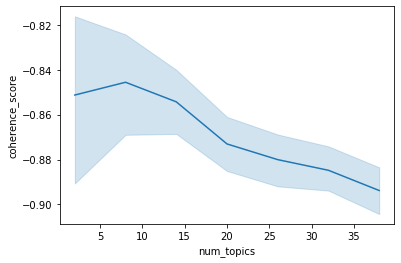

In [125]:
import seaborn as sns

ax = sns.lineplot(x="num_topics", y="coherence_score", data=topic_coherence)

In [76]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.2785
Num Topics = 8  has Coherence Value of 0.3029
Num Topics = 14  has Coherence Value of 0.2887
Num Topics = 20  has Coherence Value of 0.2852
Num Topics = 26  has Coherence Value of 0.2846
Num Topics = 32  has Coherence Value of 0.2914
Num Topics = 38  has Coherence Value of 0.2878


In [89]:
lda[id2word.doc2bow(tokenize("This is a sample document to score with a topic distribution."))]

[(0, 0.02226036),
 (1, 0.022260414),
 (2, 0.022260347),
 (3, 0.022260347),
 (4, 0.022260392),
 (5, 0.0222604),
 (6, 0.022260347),
 (7, 0.35487327),
 (8, 0.022260398),
 (9, 0.022260517),
 (10, 0.022260416),
 (11, 0.022260422),
 (12, 0.3557417),
 (13, 0.022260347),
 (14, 0.022260347)]

## Challenge
### *Can we see if one of the authors focus more on men than women?*

*  Use Spacy for text prepocessing
*  Extract the Named Entities from the documents using Spacy (command is fairly straight forward)
*  Create unique list of names from the authors (you'll find that there are different types of named entities not all people)
*  Label the names with genders (can you this by hand or you use the US census name lists)
*  Customize your processing to replace the proper name with your gender from the previous step's lookup table
*  Then follow the rest of the LDA flow

In [78]:
import spacy

nlp = spacy.load('en_core_web_lg')

/Users/jonathansokoll/anaconda3/envs/U4-S1-NLP/lib/python3.7/site-packages/thinc/neural/train.py:7: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from .optimizers import Adam, linear_decay
/Users/jonathansokoll/anaconda3/envs/U4-S1-NLP/lib/python3.7/site-packages/thinc/check.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence, Sized, Iterable, Callable
/Users/jonathansokoll/anaconda3/envs/U4-S1-NLP/lib/python3.7/site-packages/thinc/check.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence, Sized, Iterable, Callable


In [79]:
test = "Ned asked me a question about England today."

In [80]:
doc = nlp(test)

for token in doc:
    print(token.text, token.lemma_, token.pos_)

Ned Ned PROPN
asked ask VERB
me -PRON- PRON
a a DET
question question NOUN
about about ADP
England England PROPN
today today NOUN
. . PUNCT


In [81]:
for ent in doc.ents:
    print(ent.text, ent.label_)

Ned PERSON
England GPE
today DATE


In [82]:
def doc_stream(path):
    for f in os.listdir(path):
        with open(os.path.join(path,f)) as t:
            text = t.read().strip('\n')
            yield text

def get_people(docstream):
    
    ppl = []
    
    for d in docstream:
        
        doc = nlp(d)
        
        for ent in doc.ents:
            
            if ent.label_ == "PERSON":
                ppl.append(ent.lemma_)
                
    return set(ppl)

In [129]:
people = get_people(doc_stream(path))

In [126]:
doc = nlp(next(doc_stream(path)))

In [128]:
doc.ents[0].lemma_

'yesterday'

# Sources

### *References*
* [Andrew Ng et al paper on LDA](https://ai.stanford.edu/~ang/papers/jair03-lda.pdf)
* On [Coherence](https://pdfs.semanticscholar.org/1521/8d9c029cbb903ae7c729b2c644c24994c201.pdf)

### *Resources*

* [Gensim](https://radimrehurek.com/gensim/): Python package for topic modeling, nlp, word vectorization, and few other things. Well maintained and well documented.
* [Topic Modeling with Gensim](http://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#11createthedictionaryandcorpusneededfortopicmodeling): A kind of cookbook for LDA with gensim. Excellent overview, but the you need to be aware of missing import statements and assumed prior knowledge.
* [Chinese Restuarant Process](https://en.wikipedia.org/wiki/Chinese_restaurant_process): That really obscure stats thing I mentioned... 
* [PyLDAvis](https://github.com/bmabey/pyLDAvis): Library for visualizing the topic model and performing some exploratory work. Works well. Has a direct parrell implementation in R as well. 
* [Rare Technologies](https://rare-technologies.com/): The people that made & maintain gensim and a few other libraries.
* [Jane Austen v. Charlotte Bronte](https://www.literaryladiesguide.com/literary-musings/jane-austen-charlotte-bronte-different-alike/)